# Donors Choose - Data Pre-processing
## David Modjeska
## Kaggle Competition
## March-April 2018

In [1]:
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os.path
import pandas as pd
import re
import seaborn as sns
import string
import xgboost as xgb

from datetime import datetime, date, time
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from textblob import TextBlob 

%matplotlib inline
from IPython.display import Image, display, HTML

In [2]:
def my_display(str): 
    display(HTML(str))
    
def my_display_df(df): 
    display(HTML(df.to_html(index=False)))
    
def my_linespace():
    my_display('<p>')
    
plt.rcParams["patch.force_edgecolor"] = True   
plt.style.use('ggplot')

palette = sns.color_palette(palette = 'deep')
sns.set_palette(palette)

yes_no_palette = ['orange', 'green']

In [3]:
from donors_choose_info import *

In [4]:
suffix = ''

# Project Data

### Create Dictionaries

In [5]:
# create dictionary for gender by teacher title
gender_dict = {
    'Mr.' : 0,
    'Mrs.' : 1,
    'Ms.' : 1,
    'Teacher' : 2,
    'Dr.' : 2,
    '(missing)' : 2
}

In [6]:
# create dictionary for grade category
grade_category_dict = {
    'Grades PreK-2' : 0,
    'Grades 3-5' : 1,
    'Grades 6-8' : 2,
    'Grades 9-12' : 3
}

### Load, Clean, and Show Data

In [7]:
# helper function to load and show data
def load_and_show_data(filename):

    data = pd.read_csv(filename)
    
    # show data
    print("Shape of full project data: ", data.shape)
    my_display_df(data.head())

    # check for duplicate records
    my_display('Number of duplicated records: ' + str(data.duplicated().sum()))
    my_display('Number of duplicated IDs: ' + str(data.id.duplicated().sum()))

    # check for null values
    my_linespace()
    print('Columns containing nulls:')
    results = pd.DataFrame(data.isnull().sum()).reset_index().rename(columns = {'index' : 'column'})
    results.columns = ['column', 'nulls']
    results = results.loc[results.nulls > 0, ]
    my_display_df(results)

    return(data)

In [8]:
def clean_data(data):

    # give columns friendly names
    data = data.rename(columns = {
        'teacher_number_of_previously_posted_projects' : 'teacher_num_prev_posted_projs',
        'project_submitted_datetime' : 'project_submit_datetime'
    })

    ## fill nulls
    data.teacher_prefix.fillna('(missing)', inplace = True)

    # adjust data types
    data.teacher_num_prev_posted_projs = \
        data.teacher_num_prev_posted_projs.astype('int')

    # preprocess dates and times
    data.project_submit_datetime = pd.to_datetime(data.project_submit_datetime)
    
    # display date limits
    my_linespace()
    my_display('First Day: ' + str(data.project_submit_datetime.dt.date.min()))
    my_display('Last Day: ' + str(data.project_submit_datetime.dt.date.max()))    

    return(data)

In [9]:
def process_subcategories(data):
    data['lit'] = data.project_subject_subcategories.str.contains('Literacy').astype('int')
    data['math'] = data.project_subject_subcategories.str.contains('Mathematics').astype('int')
    data['lit_and_writing'] = data.project_subject_subcategories.str.contains('Literature & Writing').astype('int')
    data['special_needs_2'] = data.project_subject_subcategories.str.contains('Special Needs').astype('int')
    data['health_and_well'] = data.project_subject_subcategories.str.contains('Health & Wellness').astype('int')
    data['app_sci'] = data.project_subject_subcategories.str.contains('Appied Sciences').astype('int')
    data['gym_and_fit'] = data.project_subject_subcategories.str.contains('Gym & Fitness').astype('int')                                                                           
    data['vis_arts'] = data.project_subject_subcategories.str.contains('Visual Arts').astype('int')
    data['esl'] = data.project_subject_subcategories.str.contains('ESL').astype('int')
    data['music'] = data.project_subject_subcategories.str.contains('Music').astype('int')
    data['warmth'] = data.project_subject_subcategories.str.contains('Warmth').astype('int')
    data['care_and_hunger'] = data.project_subject_subcategories.str.contains('Care & Hunger').astype('int')
    data['env_sci'] = data.project_subject_subcategories.str.contains('Environmental Science').astype('int')
    data['team_sports'] = data.project_subject_subcategories.str.contains('Team Sports').astype('int')                                                                            
    data['health_and_life_sci'] = data.project_subject_subcategories.str.contains('Health & Life Science').astype('int')
    data['perform_arts'] = data.project_subject_subcategories.str.contains('Performing Arts').astype('int')
    data['early_dev'] = data.project_subject_subcategories.str.contains('Early Development').astype('int')
    data['other'] = data.project_subject_subcategories.str.contains('Other').astype('int')
    data['languages'] = data.project_subject_subcategories.str.contains('Foreign Languages').astype('int')
    data['parent_involve'] = data.project_subject_subcategories.str.contains('Parent Involvement').astype('int')
    data['civ_and_gov'] = data.project_subject_subcategories.str.contains('Civics & Government').astype('int')  
    data['fin_lit'] = data.project_subject_subcategories.str.contains('Financial Literacy').astype('int')
    data['econ'] = data.project_subject_subcategories.str.contains('Economics').astype('int')
    data['comm_serve'] = data.project_subject_subcategories.str.contains('Community Service').astype('int')
    data['nutrition'] = data.project_subject_subcategories.str.contains('Nutrition Education').astype('int')
    data['extracurricular'] = data.project_subject_subcategories.str.contains('Extracurricular').astype('int')
    data['soc_sci'] = data.project_subject_subcategories.str.contains('Social Sciences').astype('int')
    data['hist_and_geo'] = data.project_subject_subcategories.str.contains('History & Geography').astype('int') 
    data['college_and_career'] = data.project_subject_subcategories.str.contains('College & Career Prep').astype('int') 
    
    data['num_subcategories'] = data.project_subject_subcategories.str.count(',') + 1    
    data = data.drop('project_subject_subcategories', axis = 1)
    return(data)

In [10]:
# helper function to create features
def create_features(data):
    first_program_date = pd.to_datetime('1 January 2000')
    one_day = np.timedelta64(1, 'D')
    
    # date and time
    data['hour_of_day'] = data.project_submit_datetime.dt.hour.astype('int')
    data['day_of_week'] = data.project_submit_datetime.dt.dayofweek.astype('int')
    data['day_of_month'] = data.project_submit_datetime.dt.day.astype('int')
    data['month_of_year'] = data.project_submit_datetime.dt.month.astype('int')
    data['year'] = data.project_submit_datetime.dt.year.astype('int')
    data['date_index'] = (data.project_submit_datetime - first_program_date).astype('timedelta64[D]').astype('int')

    # gender, grade, and state
    data['gender'] = data.teacher_prefix.replace(gender_dict)
    data['grade_category'] = data.project_grade_category.replace(grade_category_dict)
    data['state'] = data.school_state.replace(state_dict)
    data = data.drop(['project_grade_category', 'school_state'], axis = 1)

    # category
    data['lit_and_lang'] = data.project_subject_categories.str.contains('Literacy & Language').astype('int')
    data['math_and_sci'] = data.project_subject_categories.str.contains('Math & Science').astype('int')
    data['health_and_sports'] = data.project_subject_categories.str.contains('Health & Sports').astype('int')
    data['special_needs'] = data.project_subject_categories.str.contains('Special Needs').astype('int')
    data['hist_and_civ'] = data.project_subject_categories.str.contains('History & Civics').astype('int')
    data['care'] = data.project_subject_categories.str.contains('Warmth, Care & Hunger').astype('int')
    data['applied_learning'] = data.project_subject_categories.str.contains('Applied Learning').astype('int')
    data['num_categories'] = data.project_subject_categories.str.count(',') + 1
    data = data.drop('project_subject_categories', axis = 1)   
    
    # subcategory
    data = process_subcategories(data)
    
    return(data)

In [11]:
# helper function to adjust essay column names
def adjust_essay_col_names(data):
    
    # separate old and new data
    first_new_date = pd.to_datetime("17 May 2016")
    old_data = data.loc[data.project_submit_datetime < first_new_date, ]
    new_data = data.loc[data.project_submit_datetime >= first_new_date, ]

    # for old data only, append essay 1 to essay 2, and essay 3 to essay 4
    old_data.project_essay_2.str.cat(old_data.project_essay_1.values, sep = ' ')
    old_data.project_essay_4.str.cat(old_data.project_essay_3.values, sep = ' ')
    
    # for old data, drop essays 1 and 3; for new data, drop essays 3 and 4
    old_data = old_data.drop(['project_essay_1', 'project_essay_3'], axis = 1)
    new_data = new_data.drop(['project_essay_3', 'project_essay_4'], axis = 1)

    # for old data, rename essay to essay 1, and essay 4 to essay 2
    old_data = old_data.rename(columns = {
        'project_essay_2' : 'project_essay_1',
        'project_essay_4' : 'project_essay_2'
    })

    # combine old and new data
    data = pd.concat([old_data, new_data], axis = 0)
    data = data.rename(columns = {
        'project_essay_1' : 'essay_1',
        'project_essay_2' : 'essay_2'
    })
    
    return(data)

In [12]:
# helper function to prepare project data
def prep_proj_data(filename):
    data = load_and_show_data(filename)
    data = clean_data(data)
    data = create_features(data)
    data = adjust_essay_col_names(data)

    data.describe()

    return(data)

# Resources Data

In [13]:
def agg_res_data_by_project(data):
    grouped_data_by_project = data.groupby('id')
    
    per_project_resources_data = grouped_data_by_project['price', 'quantity'].agg('sum').reset_index()
    per_project_resources_data['project_min_price'] = grouped_data_by_project['price'].agg('min').reset_index().drop('id', axis = 1)  
    per_project_resources_data['project_mean_price'] = grouped_data_by_project['price'].agg('mean').reset_index().drop('id', axis = 1)      
    per_project_resources_data['project_max_price'] = grouped_data_by_project['price'].agg('max').reset_index().drop('id', axis = 1) 
    per_project_resources_data['project_min_quantity'] = grouped_data_by_project['quantity'].agg('min').reset_index().drop('id', axis = 1)  
    per_project_resources_data['project_mean_quantity'] = grouped_data_by_project['quantity'].agg('mean').reset_index().drop('id', axis = 1)      
    per_project_resources_data['project_max_quantity'] = grouped_data_by_project['quantity'].agg('max').reset_index().drop('id', axis = 1)     
    per_project_resources_data['res_description'] = \
        grouped_data_by_project.description.apply(' '.join).reset_index().drop('id', axis = 1)  
    per_project_resources_data = \
        per_project_resources_data.rename(columns = {'price' : 'project_price', 'quantity' : 'project_quantity'})
    
    return(per_project_resources_data)

In [14]:
def agg_data_by_teacher(data):
    grouped_data_per_teacher = data.groupby('teacher_id')
    
    per_teacher_resources_data = grouped_data_per_teacher['project_price', 'project_quantity'].agg('sum').reset_index()
    per_teacher_resources_data['teacher_min_price'] = grouped_data_per_teacher['project_price'].agg('min').reset_index().drop('teacher_id', axis = 1)  
    per_teacher_resources_data['teacher_mean_price'] = grouped_data_per_teacher['project_price'].agg('mean').reset_index().drop('teacher_id', axis = 1)      
    per_teacher_resources_data['teacher_max_price'] = grouped_data_per_teacher['project_price'].agg('max').reset_index().drop('teacher_id', axis = 1) 
    per_teacher_resources_data['teacher_min_quantity'] = grouped_data_per_teacher['project_quantity'].agg('min').reset_index().drop('teacher_id', axis = 1)  
    per_teacher_resources_data['teacher_mean_quantity'] = grouped_data_per_teacher['project_quantity'].agg('mean').reset_index().drop('teacher_id', axis = 1)      
    per_teacher_resources_data['teacher_max_quantity'] = grouped_data_per_teacher['project_quantity'].agg('max').reset_index().drop('teacher_id', axis = 1)     
    per_teacher_resources_data = per_teacher_resources_data \
        .rename(columns = {'project_price':'teacher_price', 'project_quantity' : 'teacher_quantity'}) 
    # note: don't agg res descriptions by teacher
              
    return(per_teacher_resources_data)

In [15]:
# helper function to prepare resources data
def prep_res_data():
    
    data = pd.read_csv("resources.csv")
    print("Shape of full resources data: ", data.shape)
    data.head()

    # check for null values and handle them
    data.isnull().sum()
    data.description.fillna('(missing)', inplace = True)

    # check for dupicated records
    my_display('Number of duplicated records: ' + str(data.duplicated().sum()))
    my_display('Number of duplicated IDs: ' + str(data.id.duplicated().sum()))

    data.describe()

    # review the most expensive items for anomalies
    data.sort_values(by = 'price', ascending = False).head(10)

    # review the most numerous items for anomalies
    data.sort_values(by = 'quantity', ascending = False).head(10)
    
    # agg data by project
    per_project_resources_data = agg_res_data_by_project(data)  
    
    # create price/item feature
    per_project_resources_data['project_price_per_item'] = \
        per_project_resources_data.project_price / per_project_resources_data.project_quantity

    return(per_project_resources_data)

# Project and Resource Data

In [16]:
def merge_and_display_data(proj_data, per_project_resources_data):
    
    # merge per project data
    proj_and_res_data = pd.merge(left = proj_data, right = per_project_resources_data, on = 'id', how = 'left')
    proj_and_res_data['cur_price_per_total_apps'] = \
        proj_and_res_data.project_price / (proj_and_res_data.teacher_num_prev_posted_projs + 1)    

    # agg and merge per teacher data
    per_teacher_resources_data = agg_data_by_teacher(proj_and_res_data)      
    per_teacher_resources_data['teacher_price_per_item'] = \
        per_teacher_resources_data.teacher_price / per_teacher_resources_data.teacher_quantity    
    proj_and_res_data = pd \
        .merge(left = proj_and_res_data, right = per_teacher_resources_data, on = 'teacher_id', how = 'left') \
        .drop('teacher_id', axis = 1)
    
    print()
    print('Full project data shape: ', proj_data.shape)   
    print('Full merged data shape:   ', proj_and_res_data.shape)

    my_linespace()
    my_linespace()    
    my_display('Head of full project data:')
    my_display_df(proj_and_res_data.head())

    my_linespace()
    my_linespace()    
    my_display('Summary of full project data:')
    my_display_df(proj_and_res_data.describe())
    my_linespace()
    
    return(proj_and_res_data)

# Text Metrics

In [17]:
# helper function to process text metrics for one column
def process_text_metrics_col(data, source_col, target_cols):
    new_data = pd.DataFrame()
    
    # Number of words in the text ##
    new_data[target_cols[0]] = data[source_col].apply(lambda x: len(str(x).split()))

    # Number of unique words in the text ##
    new_data[target_cols[1]] = data[source_col].apply(lambda x: len(set(str(x).split())))

    # Number of characters in the text ##
    new_data[target_cols[2]] = data[source_col].apply(lambda x: len(str(x)))

    # Average length of the words in the text ##
    new_data[target_cols[3]] = data[source_col].apply(lambda x: np.median([len(w) for w in str(x).split()]))
  
    if len(target_cols) > 4:
        
        ## Number of stopwords in the text ##
        eng_stopwords = nltk.corpus.stopwords.words('english')
        new_data[target_cols[4]] = data[source_col].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

        # Number of punctuation marks in the text ##
        new_data[target_cols[5]] = data['essay_1'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

    return(new_data)

In [18]:
## helper function to analyze text metrics for all columns
def analyze_text_metrics_all_cols(data, suffix):
    new_data = pd.DataFrame()
    
    cols_1 = process_text_metrics_col(data, 'essay_1', target_cols_1)
    cols_2 = process_text_metrics_col(data, 'essay_2', target_cols_2)
    cols_3 = process_text_metrics_col(data, 'project_title', target_cols_title)
    cols_4 = process_text_metrics_col(data, 'project_resource_summary', target_cols_res_summary) 
    cols_5 = process_text_metrics_col(data, 'res_description', target_cols_res_description)     
    
    new_data = pd.concat([data.id, cols_1, cols_2, cols_3, cols_4, cols_5], axis = 1)
    return(new_data)

# Sentiment Analysis

In [19]:
def analyze_sentiment_col(data, source_col): 
    new_data = pd.DataFrame()    
    target_col_1 = source_col + '_sentiment_polarity' 
    target_col_2 = source_col + '_sentiment_subjectivity' 
    new_data[target_col_1] = data[source_col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    new_data[target_col_2] = data[source_col].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)
    
    return(new_data)

In [20]:
## helper function to analyze text metrics for all columns
def analyze_sentiment_all_cols(data):
    new_data = pd.DataFrame()
    
    cols_1 = analyze_sentiment_col(data, 'essay_1')
    cols_2 = analyze_sentiment_col(data, 'essay_2')
    cols_3 = analyze_sentiment_col(data, 'project_title')
    cols_4 = analyze_sentiment_col(data, 'project_resource_summary') 
    cols_5 = analyze_sentiment_col(data, 'res_description')     
    
    new_data = pd.concat([data.id, cols_1, cols_2, cols_3, cols_4, cols_5], axis = 1)
    return(new_data)

# Vectorize Text Data

### Stemming

In [21]:
# helper functions for stemming

def stemmed_words(doc, stemmer, analyzer):
    return (stemmer.stem(w) for w in analyzer(doc))

def take(n, seq): 
    seq = iter(seq)
    result = [] 
    try:
        for i in range(n): 
            result.append(seq.__next__())
    except StopIteration: 
        pass
    return result

In [22]:
# helper function to stem one column of text
def stem_one_text_col(data, col_name):
    stemmer = nltk.stem.SnowballStemmer(language = 'english', ignore_stopwords = True)
    analyzer = TfidfVectorizer().build_analyzer()

    for index in range(data.shape[0]):
                 data[col_name].values[index] = \
                     " ".join(take(1000, stemmed_words(data[col_name].values[index], 
                              stemmer, analyzer)))
                
    return(data)

In [23]:
# helper function to stem all text columns
def stem_all_text_cols(data):
    data = stem_one_text_col(data, 'essay_1')
    data = stem_one_text_col(data, 'essay_2')
    data = stem_one_text_col(data, 'project_title')
    data = stem_one_text_col(data, 'project_resource_summary')  
    data = stem_one_text_col(data, 'res_description')      
    
    return(data)

### Vectorizing

In [24]:
# visualize and choose number of principal components to use
def viz_pca(pca, n_pcs_to_use):
    cum_var_exp = 100.0 * pca.explained_variance_ratio_.cumsum()
    plot_n_components = round(pca.components_.shape[0])

    # plot percentage of variance not explained
    print()
    fig = plt.figure(figsize = (16, 4))
    plt.plot(100.0 - cum_var_exp[:plot_n_components])
    plt.xticks(range(0, plot_n_components, 50))
    plt.xlabel('Number of principal components')
    plt.ylabel('% of variance not explained')
    plt.title('Scree plot for PCA')
    plt.show()

    # print cumlative percentage of variance explained
    my_linespace()
    my_display('Percentage of variance explained by ' + 
          str(n_pcs_to_use) + 
          ' principal components: ' +
          str(round(cum_var_exp[n_pcs_to_use], 2)) +
          '%')
    my_linespace()

In [25]:
tfidf_max_features = 4000

# helper function to vectorize one column
def vectorize_one_text_col(data, col_name, n_components, prefix):
    vectorizer = TfidfVectorizer(stop_words='english', use_idf = True, ngram_range = (1, 1),
                                    max_features = tfidf_max_features)
    tfidf = vectorizer.fit_transform(data[col_name].values)
    print(tfidf.shape)
    
    ## reduce the data

    tfidf_array = tfidf.toarray()

    pca = PCA(n_components = n_components, svd_solver = 'auto', random_state = 0)
    pca.fit(tfidf_array)

    viz_pca(pca, n_components - 1)

    pca_data = pca.transform(tfidf_array)
    pca_data_df = pd.DataFrame(pca_data)
    pca_data_df.columns = [prefix + str(num) for num in range(pca_data.shape[1])]
    
    return(pca_data_df)

In [26]:
# helper function to vectorize all text columns
def vectorize_all_text_cols(data):
    n_components = 100
    
    pca_essay_1_data_df = vectorize_one_text_col(data, 'essay_1', n_components, 'X')
    pca_essay_2_data_df = vectorize_one_text_col(data, 'essay_2', n_components, 'Y')
    pca_title_data_df = vectorize_one_text_col(data, 'project_title', n_components, 'Z')
    pca_res_summary_data_df = vectorize_one_text_col(data, 'project_resource_summary', n_components, 'W') 
    pca_res_description_data_df = vectorize_one_text_col(data, 'res_description', n_components, 'V')     
    
    return(pca_essay_1_data_df, pca_essay_2_data_df, pca_title_data_df, pca_res_summary_data_df, 
           pca_res_description_data_df)

# Finalize Preprocessing

In [27]:
per_project_resources_data = prep_res_data()

Shape of full resources data:  (1541272, 4)


In [28]:
# helper function to one-hot encode qualitative columns 
def encode_qual_cols(data):
    
    # teacher prefix
    prefix_encoder = LabelEncoder()
    encoded_prefix_col = prefix_encoder.fit_transform(data.teacher_prefix.values)
    encoded_prefix_col_df = pd.DataFrame(encoded_prefix_col)
    encoded_prefix_col_df.columns = ['encoded_teacher_prefix']    
    
    data = pd.concat([data, encoded_prefix_col_df], axis = 1)    
    return(data)

In [29]:
# helper function to one-hot encode qualitative columns 
def one_hot_encode_qual_cols(data):
    
    # state
    state_encoder = OneHotEncoder(n_values = len(state_dict), sparse = False)
    encoded_state_cols = state_encoder.fit_transform(data.state.values.reshape(-1, 1))
    encoded_state_cols_df = pd.DataFrame(encoded_state_cols)
    encoded_state_cols_df.columns = ['S' + str(num) for num in range(encoded_state_cols_df.shape[1])]

    # teacher prefix
    prefix_encoder = OneHotEncoder(n_values = len(data.encoded_teacher_prefix.value_counts()), sparse = False)
    encoded_prefix_cols = prefix_encoder.fit_transform(data.encoded_teacher_prefix.values.reshape(-1, 1))
    encoded_prefix_cols_df = pd.DataFrame(encoded_prefix_cols)
    encoded_prefix_cols_df.columns = ['P' + str(num) for num in range(encoded_prefix_cols_df.shape[1])]
    
    # gender
    gender_encoder = OneHotEncoder(n_values = len(gender_dict), sparse = False)
    encoded_gender_cols = gender_encoder.fit_transform(data.gender.values.reshape(-1, 1))
    encoded_gender_cols_df = pd.DataFrame(encoded_gender_cols)
    encoded_gender_cols_df.columns = ['G' + str(num) for num in range(encoded_gender_cols_df.shape[1])]

    data = data.drop(['encoded_teacher_prefix'], axis = 1)
    data = pd.concat([data, encoded_state_cols_df, encoded_prefix_cols_df, encoded_gender_cols_df], axis = 1)
    
    return(data)

In [30]:
def prep_data(source_filename, per_project_resources_data, prefix):
    out_filename = 'processed_' + prefix + '_data.csv'
    proj_data = prep_proj_data(source_filename)
    proj_and_res_data = merge_and_display_data(proj_data, per_project_resources_data)
    
    # calculate or load text metrics
    text_metrics_filename = 'text_metrics_' + prefix + '.csv'
    if not os.path.isfile(text_metrics_filename):
        metrics_cols = analyze_text_metrics_all_cols(proj_and_res_data, prefix)
        metrics_cols.to_csv(text_metrics_filename, index = False)
    text_metrics = pd.read_csv(text_metrics_filename)
    proj_and_res_data = proj_and_res_data.merge(text_metrics, how = 'inner', on = 'id')
        
    # compute or load sentiment analysis
    sentiment_filename = 'sentiment_' + prefix + '.csv'
    if not os.path.isfile(sentiment_filename):
        sentiment_cols = analyze_sentiment_all_cols(proj_and_res_data)
        sentiment_cols.to_csv(sentiment_filename, index = False)
    sentiment_cols = pd.read_csv(sentiment_filename)     
    proj_and_res_data = proj_and_res_data.merge(sentiment_cols, how = 'inner', on = 'id')
    
    # stem and vectorize text
    proj_and_res_data = stem_all_text_cols(proj_and_res_data)
    pca_essay_1_data_df, pca_essay_2_data_df, pca_title_data_df, pca_res_summary_data_df, pca_res_description_data_df = \
        vectorize_all_text_cols(proj_and_res_data)

    # drop extra columns
    proj_and_res_data = proj_and_res_data.drop(['essay_1', 'essay_2', 'project_title', 
                                                'project_resource_summary', 'res_description'], 
                                               axis = 1)

    # merge general and text data
    full_data = pd.concat([proj_and_res_data, pca_essay_1_data_df, pca_essay_2_data_df, pca_title_data_df, 
                           pca_res_summary_data_df, pca_res_description_data_df], 
                          axis = 1)
           
    return(full_data, out_filename)

Shape of full project data:  (182080, 16)


id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


Columns containing nulls:


column,nulls
teacher_prefix,4
project_essay_3,175706
project_essay_4,175706



Full project data shape:  (182080, 57)
Full merged data shape:    (182080, 76)


id,teacher_prefix,project_submit_datetime,project_title,essay_1,essay_2,project_resource_summary,teacher_num_prev_posted_projs,project_is_approved,hour_of_day,day_of_week,day_of_month,month_of_year,year,date_index,gender,grade_category,state,lit_and_lang,math_and_sci,health_and_sports,special_needs,hist_and_civ,care,applied_learning,num_categories,lit,math,lit_and_writing,special_needs_2,health_and_well,app_sci,gym_and_fit,vis_arts,esl,music,warmth,care_and_hunger,env_sci,team_sports,health_and_life_sci,perform_arts,early_dev,other,languages,parent_involve,civ_and_gov,fin_lit,econ,comm_serve,nutrition,extracurricular,soc_sci,hist_and_geo,college_and_career,num_subcategories,project_price,project_quantity,project_min_price,project_mean_price,project_max_price,project_min_quantity,project_mean_quantity,project_max_quantity,res_description,project_price_per_item,cur_price_per_total_apps,teacher_price,teacher_quantity,teacher_min_price,teacher_mean_price,teacher_max_price,teacher_min_quantity,teacher_mean_quantity,teacher_max_quantity,teacher_price_per_item
p232007,Mrs.,2016-04-27 09:58:04,Watch Readers Grow!,My students lack confidence. I have a class wi...,Your donations would greatly be a blessing for...,My students need these reading materials to he...,6,1,9,2,27,4,2016,5961,1,0,10,1,0,0,0,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,467.97,5,39.99,93.5940,169.00,1,1.0,1,DD280X - Quick-Pick Language Student Activity ...,93.5940,66.852857,3074.83,112,101.17,384.35375,789.38,2,14.0,34,27.453839
p164867,Mr.,2016-05-16 19:24:22,Reader's Workshop Exploration Club!!!,The students I have now are English language l...,Your generous donation for this class will giv...,My students need a wide assortment of high-int...,0,1,19,0,16,5,2016,5980,0,0,5,1,0,0,0,1,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,481.00,16,22.00,30.0625,41.00,1,1.0,1,LL719 - Level I Nonfiction Extra Book Set - Gr...,30.0625,481.000000,481.00,16,481.00,481.00000,481.00,16,16.0,16,30.062500
p141508,Ms.,2016-05-06 11:46:38,World History Biographies varied by lexile,"90% of my students are multi-lingual, usually ...","With these new books, students will be able to...",My students need world history books at a vari...,0,1,11,4,6,5,2016,5970,1,3,36,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,502.35,17,4.34,29.5500,104.03,1,1.0,1,9-10 Common Core Exemplar Informational Texts:...,29.5500,502.350000,502.35,17,502.35,502.35000,502.35,17,17.0,17,29.550000
p229044,Ms.,2016-05-10 12:23:36,A sensory rich classroom,I am the lucky teacher of 6th-8th graders who ...,I strive to create a classroom where I can tak...,My students need different types of sensory se...,0,1,12,1,10,5,2016,5974,1,2,6,0,0,0,1,0,0,1,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,220.32,6,13.95,55.0800,131.99,1,1.5,2,"Air Stability Wobble Cushion, Blue, 35cm/14in ...",36.7200,220.320000,220.32,6,220.32,220.32000,220.32,6,6.0,6,36.720000
p193494,Ms.,2016-05-06 09:42:23,Magic in Making Music,Our class is full of energy and excitement. T...,This will give students a chance to express th...,My students need rhythm instruments for our cl...,1,1,9,4,6,5,2016,5970,1,0,49,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,246.46,1,246.46,246.4600,246.46,1,1.0,1,101 Rhythm Instruments Kit,246.4600,123.230000,246.46,1,246.46,246.46000,246.46,1,1.0,1,246.460000


teacher_num_prev_posted_projs,project_is_approved,hour_of_day,day_of_week,day_of_month,month_of_year,year,date_index,gender,grade_category,state,lit_and_lang,math_and_sci,health_and_sports,special_needs,hist_and_civ,care,applied_learning,num_categories,lit,math,lit_and_writing,special_needs_2,health_and_well,app_sci,gym_and_fit,vis_arts,esl,music,warmth,care_and_hunger,env_sci,team_sports,health_and_life_sci,perform_arts,early_dev,other,languages,parent_involve,civ_and_gov,fin_lit,econ,comm_serve,nutrition,extracurricular,soc_sci,hist_and_geo,college_and_career,num_subcategories,project_price,project_quantity,project_min_price,project_mean_price,project_max_price,project_min_quantity,project_mean_quantity,project_max_quantity,project_price_per_item,cur_price_per_total_apps,teacher_price,teacher_quantity,teacher_min_price,teacher_mean_price,teacher_max_price,teacher_min_quantity,teacher_mean_quantity,teacher_max_quantity,teacher_price_per_item
182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.0,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.00000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000
11.237055,0.847682,14.461160,2.670546,15.326757,6.845606,2016.277938,6137.830305,0.924621,0.950181,25.779306,0.477746,0.380316,0.130228,0.125665,0.053416,0.012780,0.111506,1.398100,0.312961,0.257491,0.203065,0.125665,0.093909,0.0,0.041696,0.057112,0.039334,0.028405,0.012780,0.012780,0.051823,0.020008,0.039406,0.017701,0.039263,0.021683,0.008216,0.006058,0.007107,0.00525,0.002367,0.003910,0.012280,0.007315,0.017295,0.028877,0.023567,1.610281,297.731304,16.971447,90.902456,122.430852,178.380353,4.107354,5.234677,7.666070,91.686459,131.963752,1258.727777,71.353718,194.208513,297.731304,482.234656,10.423561,16.971447,29.276104,62.144115
28.016086,0.359330,5.766492,1.870737,9.154101,3.299685,0.447984,95.788323,0.336151,0.980029,16.591966,0.499506,0.485466,0.336556,0.331472,0.224862,0.112325,0.314758,0.491031,0.463700,0.437253,0.402281,0.331472,0.291703,0.0,0.199894,0.232058,0.194390,0.166128,0.112325,0.112325,0.221671,0.140027,0.194559,0.131863,0.194220,0.145646,0.090270,0.077596,0.084002,0.07227,0.048595,0.062411,0.110134,0.085217,0.130367,0.167462,0.151695,0.489217,366.718002,26.241957,271.538578,274.554270,307.067793,11.604126,12.092317,15.994654,271.896385,218.296233,2302.245505,134.340663,265.480710,287.889686,639.347784,20.458998,22.115050,38.550905,174.710450
0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2016.000000,5961.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.660000,1.000000,0.000000,0.256667,0.270000,1.000000,1.000000,1.000000,0.001711,0.006997,0.690000,1.000000,0.660000,0.690000,0.690000,1.000000,1.000000,1.000000,0.001711
0.000000,1.000000,11.000000,1.000000,7.000000,4.000000,2016.000000,6066.000000,1.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0000

(182080, 4000)



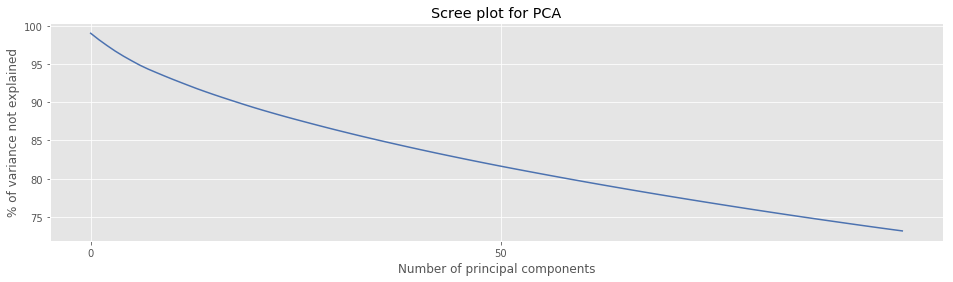

(182080, 4000)



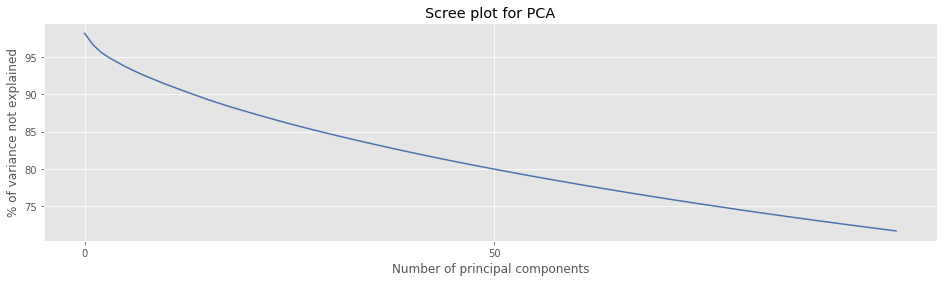

(182080, 4000)



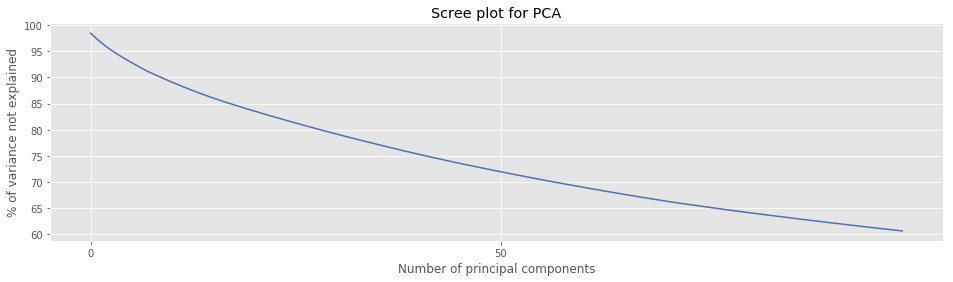

(182080, 4000)



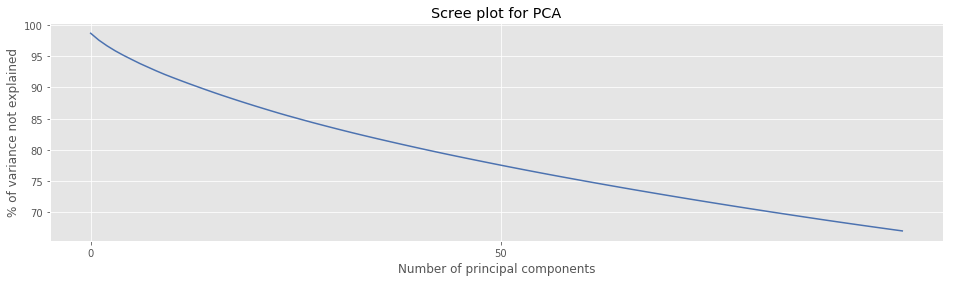

(182080, 4000)



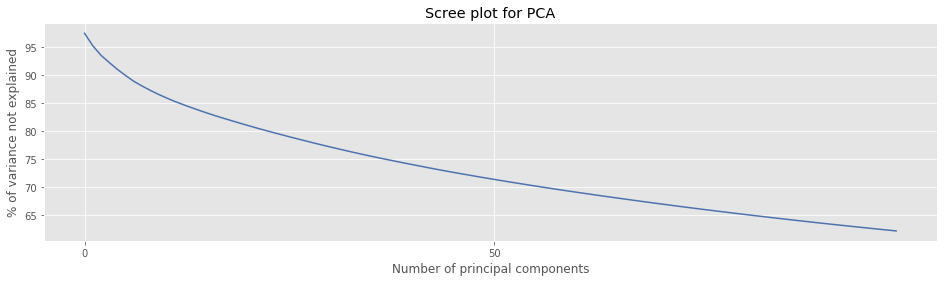

In [31]:
source = 'train'
full_train_data, train_out_filename = prep_data(source + '.csv', per_project_resources_data, source)

Shape of full project data:  (78035, 15)


/Users/davidmodjeska/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  


id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects
p233245,5724a0c3ce11008366fff36dab4b943c,Ms.,CA,2016-04-27 13:45:41,Grades PreK-2,Music & The Arts,Visual Arts,Art Will Make You Happy!,My 2nd grade students are amazing! They are v...,My class is made up of 12 boys and 12 girls. ...,My second grade class will really benefit from...,The genorous donations to my project will make...,My students need a drying rack for their art p...,2
p096795,445619941dc7cbe81c7be109dc61a56a,Mrs.,SC,2016-04-28 12:43:56,Grades 3-5,"Literacy & Language, Math & Science","Literature & Writing, Mathematics",Keeping up with the TIMEs,Students within the classroom work in small gr...,My students are all very talented young indivi...,"We do a lot of small group, where the student ...",This project is very important to my classroom...,My students need Time Magazines for next year ...,1
p236235,e92a4902b1611a189643d6f12c51e6a0,Mrs.,SC,2016-04-29 21:16:05,Grades PreK-2,Math & Science,"Applied Sciences, Mathematics",Building Bridges to Problem Solving,My students share a love of learning. These s...,My class consists of 14 energetic learners. O...,These Fairy Tale Problem Solving STEM kits wil...,These materials will be help my students with ...,My students need to be mentally stimulated to ...,0
p233680,8e92622d2985d3faac1de71609c4be72,Mrs.,IA,2016-04-27 22:32:43,Grades PreK-2,Literacy & Language,Literacy,Classroom Library,Reading is the gateway to the soul. Guiding c...,First graders enter the classroom each day rea...,Book bins will help to organize our classroom ...,"When students begin the first grade, many are ...",My students need an organized classroom library.,0
p171879,91a3c89981f626d9a0d067c65fb186ce,Mr.,CA,2016-04-27 18:59:15,Grades 6-8,"Music & The Arts, Special Needs","Performing Arts, Special Needs",Reeds so we can Read,"\""Mr. Reyes! I need another reed!\"" I hear t...",We have a diverse population with almost entir...,Each day in my class students consume supplies...,My students come from very troubled homes and ...,My students need reeds to perform in class eac...,1


Columns containing nulls:


column,nulls
teacher_prefix,1
project_essay_3,75331
project_essay_4,75331



Full project data shape:  (78035, 56)
Full merged data shape:    (78035, 75)


id,teacher_prefix,project_submit_datetime,project_title,essay_1,essay_2,project_resource_summary,teacher_num_prev_posted_projs,hour_of_day,day_of_week,day_of_month,month_of_year,year,date_index,gender,grade_category,state,lit_and_lang,math_and_sci,health_and_sports,special_needs,hist_and_civ,care,applied_learning,num_categories,lit,math,lit_and_writing,special_needs_2,health_and_well,app_sci,gym_and_fit,vis_arts,esl,music,warmth,care_and_hunger,env_sci,team_sports,health_and_life_sci,perform_arts,early_dev,other,languages,parent_involve,civ_and_gov,fin_lit,econ,comm_serve,nutrition,extracurricular,soc_sci,hist_and_geo,college_and_career,num_subcategories,project_price,project_quantity,project_min_price,project_mean_price,project_max_price,project_min_quantity,project_mean_quantity,project_max_quantity,res_description,project_price_per_item,cur_price_per_total_apps,teacher_price,teacher_quantity,teacher_min_price,teacher_mean_price,teacher_max_price,teacher_min_quantity,teacher_mean_quantity,teacher_max_quantity,teacher_price_per_item
p233245,Ms.,2016-04-27 13:45:41,Art Will Make You Happy!,My class is made up of 12 boys and 12 girls. ...,The genorous donations to my project will make...,My students need a drying rack for their art p...,2,13,2,27,4,2016,5961,1,0,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,149.00,1,149.00,149.000000,149.00,1,1.000000,1,LC652 - Lakeshore Double-Space Mobile Drying Rack,149.00000,49.666667,149.00,1,149.00,149.00,149.00,1,1.0,1,149.00000
p096795,Mrs.,2016-04-28 12:43:56,Keeping up with the TIMEs,My students are all very talented young indivi...,This project is very important to my classroom...,My students need Time Magazines for next year ...,1,12,3,28,4,2016,5962,1,1,45,1,1,0,0,0,0,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,23.98,44,5.01,7.993333,9.95,2,14.666667,40,"Brewster WPD90218 Wall Pops Flirt Dot, Set of ...",0.54500,11.990000,23.98,44,23.98,23.98,23.98,44,44.0,44,0.54500
p236235,Mrs.,2016-04-29 21:16:05,Building Bridges to Problem Solving,My class consists of 14 energetic learners. O...,These materials will be help my students with ...,My students need to be mentally stimulated to ...,0,21,4,29,4,2016,5963,1,0,45,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,149.00,2,149.00,149.000000,149.00,2,2.000000,2,PP440X - Fairy Tales Problem Solving STEM Kits,74.50000,149.000000,149.00,2,149.00,149.00,149.00,2,2.0,2,74.50000
p233680,Mrs.,2016-04-27 22:32:43,Classroom Library,First graders enter the classroom each day rea...,"When students begin the first grade, many are ...",My students need an organized classroom library.,0,22,2,27,4,2016,5961,1,0,14,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,214.90,35,4.99,19.536364,149.00,1,3.181818,5,AA758BU - Connect & Store Book Bin - Blue AA75...,6.14000,214.900000,276.88,43,61.98,138.44,214.90,8,21.5,35,6.43907
p171879,Mr.,2016-04-27 18:59:15,Reeds so we can Read,We have a diverse population with almost entir...,My students come from very troubled homes and ...,My students need reeds to perform in class eac...,1,18,2,27,4,2016,5961,0,2,5,0,0,0,1,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,154.67,8,35.29,51.556667,70.39,2,2.666667,3,"Alto Saxophone Reeds, Box of 25 Bb Clarinet Re...",19.33375,77.335000,154.67,8,154.67,154.67,154.67,8,8.0,8,19.33375


teacher_num_prev_posted_projs,hour_of_day,day_of_week,day_of_month,month_of_year,year,date_index,gender,grade_category,state,lit_and_lang,math_and_sci,health_and_sports,special_needs,hist_and_civ,care,applied_learning,num_categories,lit,math,lit_and_writing,special_needs_2,health_and_well,app_sci,gym_and_fit,vis_arts,esl,music,warmth,care_and_hunger,env_sci,team_sports,health_and_life_sci,perform_arts,early_dev,other,languages,parent_involve,civ_and_gov,fin_lit,econ,comm_serve,nutrition,extracurricular,soc_sci,hist_and_geo,college_and_career,num_subcategories,project_price,project_quantity,project_min_price,project_mean_price,project_max_price,project_min_quantity,project_mean_quantity,project_max_quantity,project_price_per_item,cur_price_per_total_apps,teacher_price,teacher_quantity,teacher_min_price,teacher_mean_price,teacher_max_price,teacher_min_quantity,teacher_mean_quantity,teacher_max_quantity,teacher_price_per_item
78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.00000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.0,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.00000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.00000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000,78035.000000
11.275082,14.463241,2.672942,15.299238,6.869969,2016.276632,6138.066214,0.921548,0.952560,25.784340,0.478298,0.376408,0.13130,0.128596,0.053015,0.013289,0.110976,1.398924,0.313308,0.256385,0.203293,0.128596,0.094291,0.0,0.041417,0.056795,0.038009,0.029025,0.013289,0.013289,0.051028,0.019876,0.037304,0.017992,0.038675,0.022208,0.00815,0.005472,0.007125,0.005344,0.002089,0.004011,0.012623,0.007253,0.01689,0.029077,0.023374,1.608112,298.460543,16.898340,93.206521,124.438603,179.870531,4.116294,5.254032,7.682437,94.008119,131.176030,727.857609,40.645595,228.517494,298.460543,406.755657,12.398103,16.898340,24.080131,72.487701
27.981717,5.760332,1.874311,9.160744,3.304159,0.447336,95.678056,0.339377,0.978826,16.555172,0.499532,0.484487,0.33773,0.334755,0.224064,0.114510,0.314104,0.490987,0.463841,0.436640,0.402452,0.334755,0.292235,0.0,0.199255,0.231452,0.191218,0.167879,0.114510,0.114510,0.220057,0.139574,0.189506,0.132923,0.192820,0.147360,0.08991,0.073770,0.084109,0.072906,0.045656,0.063206,0.111639,0.084857,0.12886,0.168023,0.151090,0.489486,373.466571,26.611139,290.536650,292.025871,319.290965,11.840619,12.338140,16.181940,290.326671,217.026528,1279.636670,70.858144,303.984709,320.559491,544.715398,22.945052,23.931891,33.605316,222.365286
0.000000,0.000000,0.000000,1.000000,1.000000,2016.000000,5961.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.900000,1.000000,0.000000,0.900000,0.900000,1.000000,1.000000,1.000000,0.002250,0.010674,0.900000,1.000000,0.900000,0.900000,0.900000,1.000000,1.000000,1.000000,0.002475
0.000000,11.000000,1.000000,7.000000,4.000000,2016.000000,6066.000000,1.000000,0.000000,10.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000

(78035, 4000)



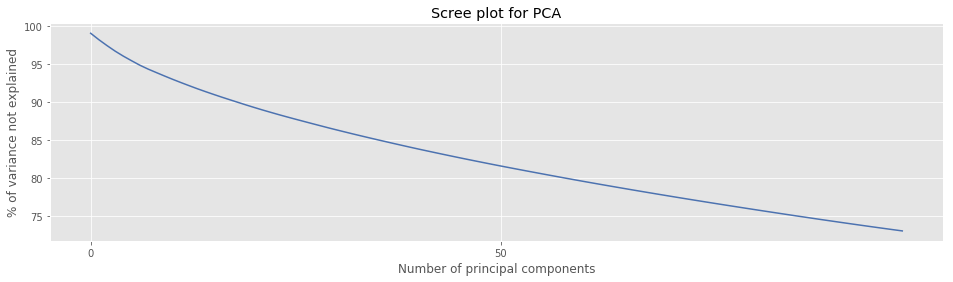

(78035, 4000)



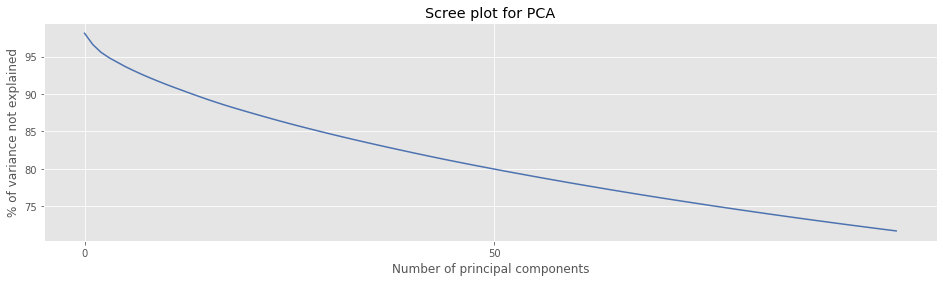

(78035, 4000)



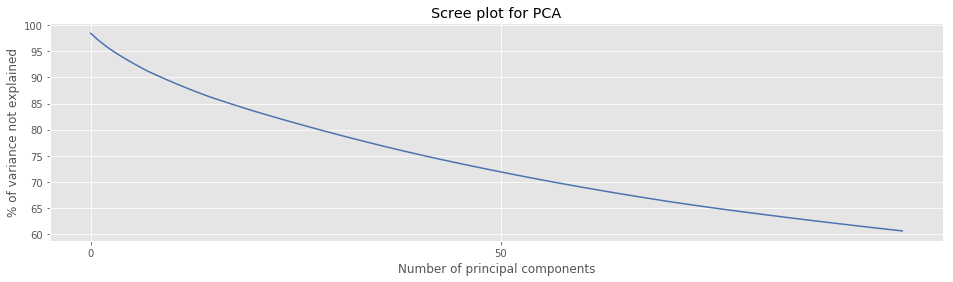

(78035, 4000)



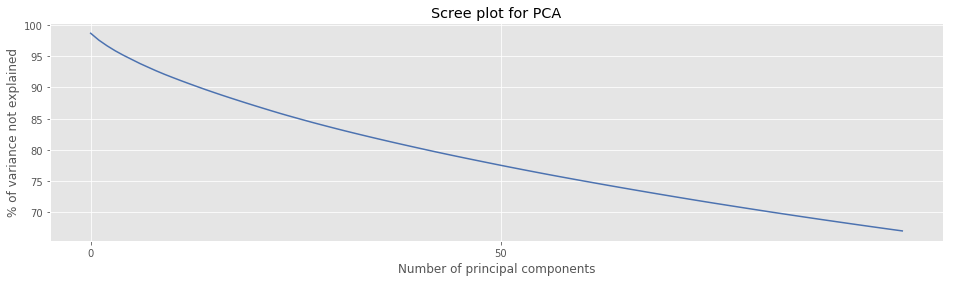

(78035, 4000)



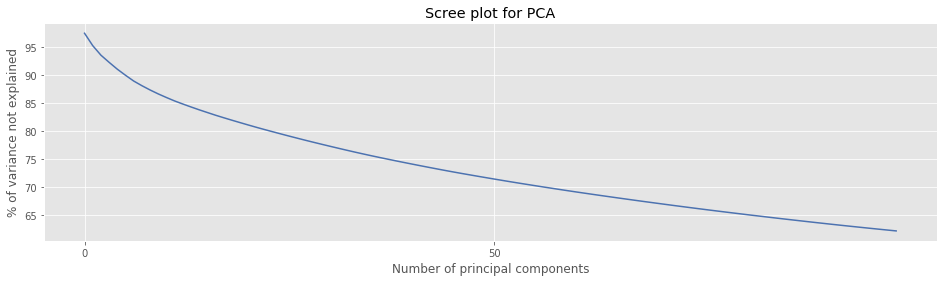

In [32]:
source = 'test' + suffix
full_test_data, test_out_filename = prep_data(source + '.csv', per_project_resources_data, source)

In [33]:
## temporarily combine train and test data

full_train_data['Source'] = 'train'

full_test_data['project_is_approved'] = 0
full_test_data['Source'] = 'test'

full_data = pd.concat([full_train_data, full_test_data], axis = 0).reset_index(drop = True)

In [34]:
# encode the qualitative columns
full_data = encode_qual_cols(full_data)    
full_data = one_hot_encode_qual_cols(full_data)

In [35]:
## split train and test data again

full_train_data = full_data[full_data.Source == 'train'] \
    .reset_index(drop = True) \
    .drop(['Source'], axis = 1)
    
full_test_data = full_data[full_data.Source == 'test'] \
    .reset_index(drop = True) \
    .drop(['project_is_approved','Source'], axis = 1)

In [36]:
# export data
full_train_data.to_csv(train_out_filename, index = False)
full_test_data.to_csv(test_out_filename, index = False)

print('Full training and testing data exported')

Full training and testing data exported
